In [ ]:
!pip install -q tensorflow tensorflow-probability numpy matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses, metrics
import tensorflow_probability as tfp

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: []


In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1)
x_test  = (x_test.astype("float32") / 255.0)[..., None]
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def build_encoder(latent_dim=8):
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)       # 7x7
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim=8):
    z_in = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(z_in)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same") (x)  # 14x14
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same") (x)  # 28x28
    out = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return models.Model(z_in, out, name="decoder")

class VAE(models.Model):
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = metrics.Mean(name="loss")
        self.recon_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker    = metrics.Mean(name="kl_loss")

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        recon = self.decoder(z, training=training)
        return recon

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            recon = self.decoder(z, training=True)
            recon_loss = tf.reduce_mean(losses.binary_crossentropy(x, recon) * 28 * 28)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        z_mean, z_log_var, z = self.encoder(x, training=False)
        recon = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(losses.binary_crossentropy(x, recon) * 28 * 28)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

latent_dim = 8
beta = 0.5

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder, beta=beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

print("Starting training...")
history = vae.fit(
    x_train,
    epochs=15,
    batch_size=128,
    validation_data=(x_test, x_test), )
    verbose=1
)

def fid_like(real_images, generated_images):
    real_mean = tf.reduce_mean(real_images, axis=0)
    gen_mean  = tf.reduce_mean(generated_images, axis=0)
    mean_diff = tf.reduce_sum(tf.square(real_mean - gen_mean))

    real_std = tf.math.reduce_std(real_images, axis=0)
    gen_std  = tf.math.reduce_std(generated_images, axis=0)
    std_diff = tf.reduce_sum(tf.square(real_std - gen_std))
    return float(mean_diff + std_diff)

def evaluate_model(model, test_data, num_samples=1000, latent_dim=8):
    z_mean, z_log_var, z = model.encoder.predict(test_data[:num_samples], verbose=0)
    recon = model.decoder.predict(z, verbose=0)
    mse = tf.reduce_mean(tf.square(test_data[:num_samples] - recon))

    z_prior = np.random.normal(0, 1, (num_samples, latent_dim))
    gen = model.decoder.predict(z_prior, verbose=0)
    proxy_fid = fid_like(test_data[:num_samples], gen)

    kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    return {"mse": float(mse), "fid": float(proxy_fid), "kl_divergence": float(kl), "latent_std": float(np.std(z))}

print("Evaluating model...")
metrics_out = evaluate_model(vae, x_test, num_samples=1000, latent_dim=latent_dim)
print("Evaluation Metrics:")
for k, v in metrics_out.items():
    print(f"{k}: {v:.4f}")

if not vae.built:
    vae.build(input_shape=(None, 28, 28, 1))

vae.save_weights('beta_vae_mnist.weights.h5')
print("Saved VAE weights -> beta_vae_mnist.weights.h5")

encoder.save('encoder.keras')
decoder.save('decoder.keras')
print("Saved encoder -> encoder.keras , decoder -> decoder.keras")



Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Starting training...
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 208ms/step - kl_loss: 2.7748 - loss: 245.9091 - reconstruction_loss: 244.5217 - val_kl_loss: 4.9854 - val_loss: 138.7482 - val_reconstruction_loss: 136.2555
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 207ms/step - kl_loss: 4.5578 - loss: 129.2240 - reconstruction_loss: 126.9451 - val_kl_loss: 4.1951 - val_loss: 116.5605 - val_reconstruction_loss: 114.4629
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 199ms/step - kl_loss: 4.0623 - loss: 116.1452 - reconstruction_loss: 114.1141 - val_kl_loss: 4.0384 - val_loss: 111.8641 - val_reconstruction_loss: 109.8449
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 198ms/step - kl_loss: 3.9883 - loss: 111.8050 - reconstruction_loss: 109.8108 - val_kl_loss: 4.0228 - val_loss: 109.1875 - val_reconstruction_loss: 107.1761
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 198ms/step - kl_loss: 3.9316 - loss: 108.8366 - rec

Generating visualizations...


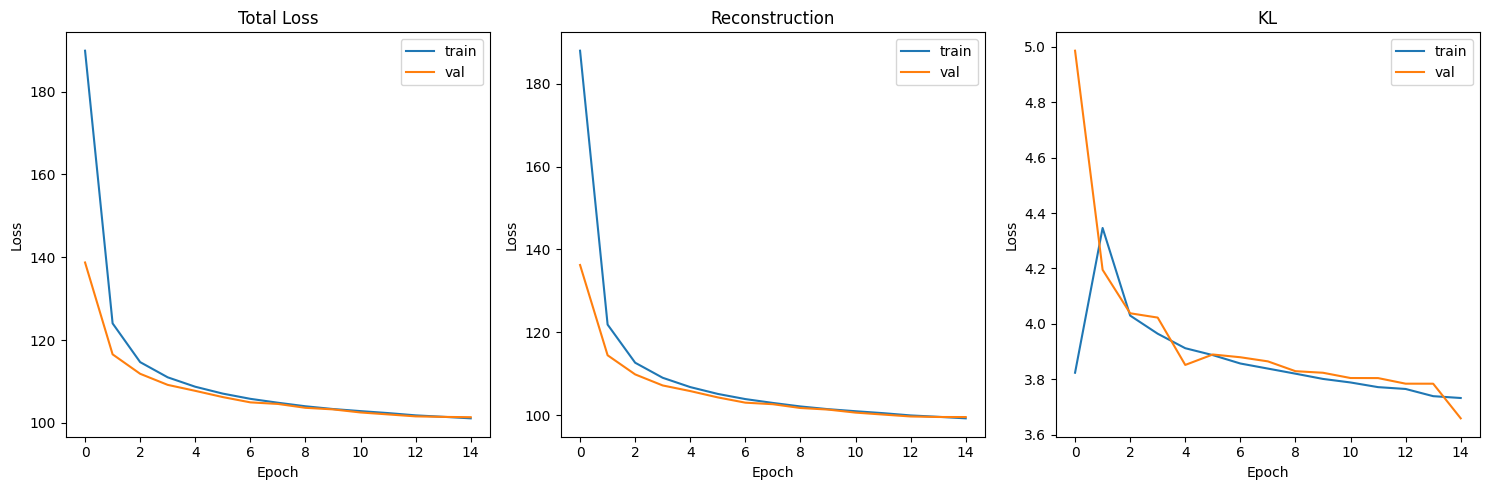

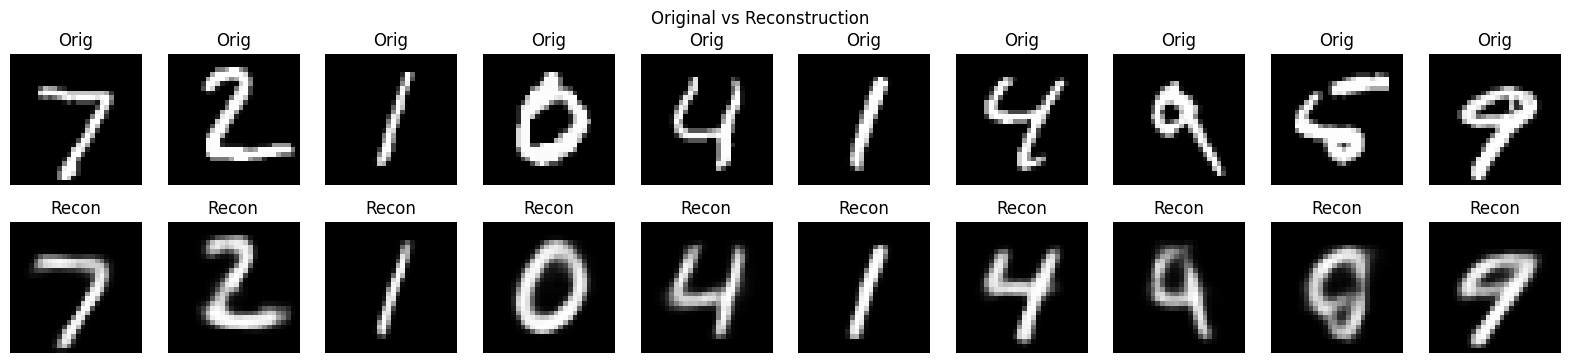

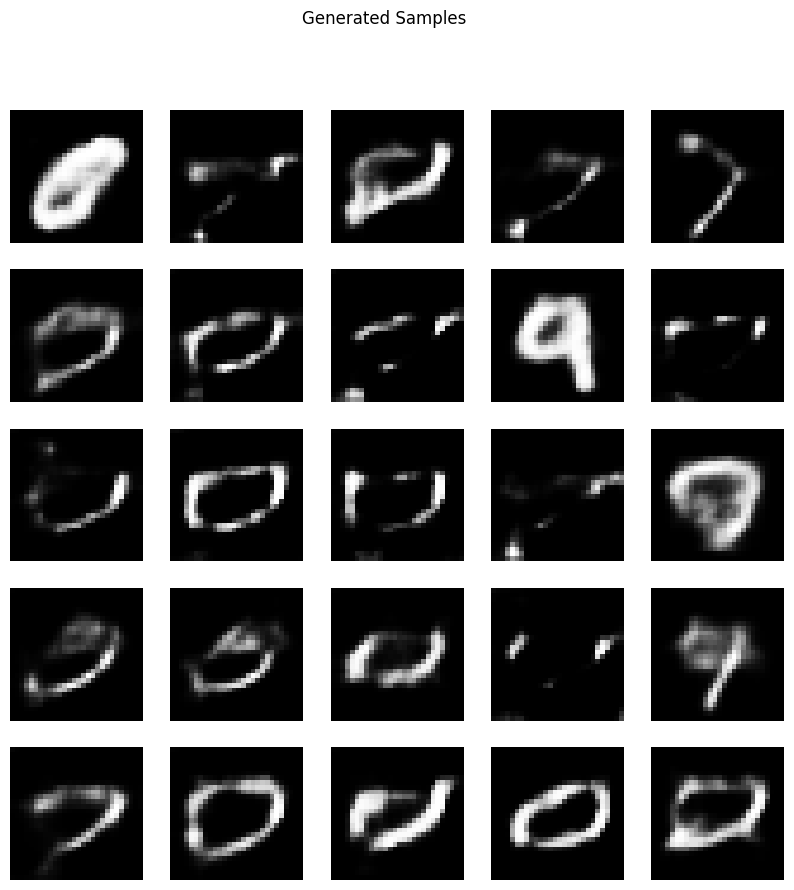

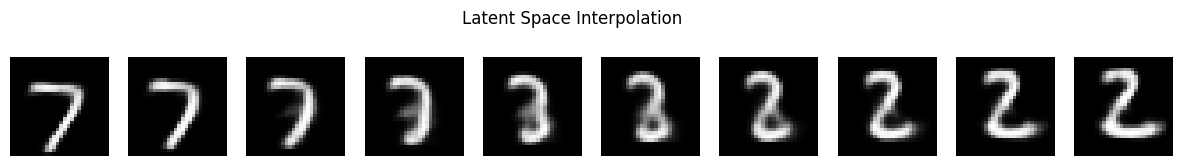

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history.get('loss', []), label='train')
    plt.plot(history.history.get('val_loss', []), label='val')
    plt.title('Total Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history.history.get('reconstruction_loss', []), label='train')
    plt.plot(history.history.get('val_reconstruction_loss', []), label='val')
    plt.title('Reconstruction'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history.history.get('kl_loss', []), label='train')
    plt.plot(history.history.get('val_kl_loss', []), label='val')
    plt.title('KL'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

def plot_reconstructions(model, test_data, n=10):
    sample = test_data[:n]
    z_mean, z_log_var, z = model.encoder.predict(sample, verbose=0)
    recon = model.decoder.predict(z, verbose=0)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(sample[i].squeeze(), cmap='gray'); plt.axis('off'); plt.title("Orig")
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i].squeeze(), cmap='gray'); plt.axis('off'); plt.title("Recon")
    plt.suptitle("Original vs Reconstruction"); plt.show()

def plot_generated_samples(model, n=25, latent_dim=8):
    z = np.random.normal(0, 1, (n, latent_dim))
    gen = model.decoder.predict(z, verbose=0)
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.subplot(5,5,i+1)
        plt.imshow(gen[i].squeeze(), cmap='gray'); plt.axis('off')
    plt.suptitle("Generated Samples"); plt.show()


print("Generating visualizations...")
plot_training_history(history)
print('')
plot_reconstructions(vae, x_test)
print('')
plot_generated_samples(vae, latent_dim=latent_dim)


def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, n_steps)
    return np.array([(1-r)*p1 + r*p2 for r in ratios])

z_mean, z_log_var, z = vae.encoder.predict(x_test[:10], verbose=0)
interp = interpolate_points(z[0], z[1], n_steps=10)
gen_interp = vae.decoder.predict(interp, verbose=0)
print('')
plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(gen_interp[i].squeeze(), cmap='gray'); plt.axis('off')
plt.suptitle("Latent Space Interpolation"); plt.show()

